In [1]:
%matplotlib inline
import warnings
import itertools
import pandas as pd
import numpy as np
import subprocess, psycopg2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from datetime import datetime

plt.style.use('ggplot')

## Get the data from the Heroku PostgreSQL database

In [2]:
HEROKU_APP_NAME = "pxl-ss"
TABLE_NAME = "Temperature"

conn_info = subprocess.run(["heroku", "config:get", "DATABASE_URL", "-a", HEROKU_APP_NAME], stdout = subprocess.PIPE)
connuri = conn_info.stdout.decode('utf-8').strip()

engine = create_engine(connuri)
raw_engine = engine.raw_connection()

data = pd.read_sql_query("SELECT * FROM Temperature;", raw_engine)

## Restructure the data to form a time series

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 2 columns):
creation_date    211 non-null datetime64[ns]
value            211 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 3.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 211 entries, 2018-11-10 23:38:44.453789 to 2018-11-12 18:35:09.911539
Data columns (total 1 columns):
value    211 non-null float64
dtypes: float64(1)
memory usage: 3.3 KB
None


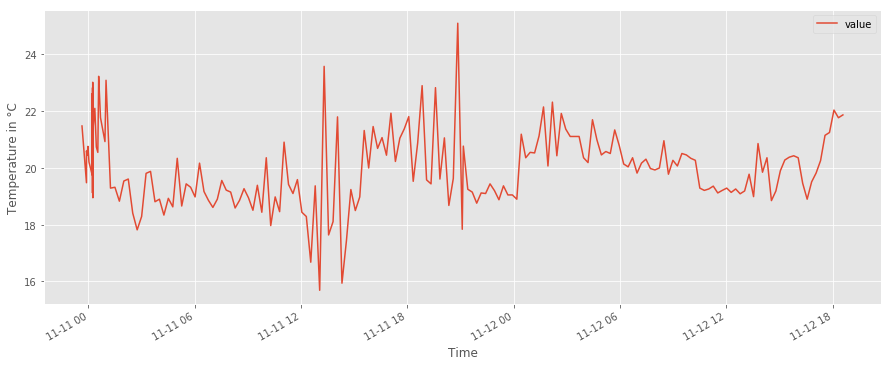

In [3]:
df = pd.DataFrame(data, columns = ['creation_date', 'value'])

# Inspect data
print(df.info())

# Convert the creation_date column to datetime64
df['creation_date'] = pd.to_datetime(df['creation_date'])
# Convert the value column to float
df['value'] = pd.to_numeric(df['value'])

# Set date_creation column as index
df.set_index('creation_date', inplace=True)

# Inspect data
print(df.info())

# Plot data
df.plot(figsize=(15, 6))
plt.ylabel("Temperature in °C")
plt.xlabel("Time")
plt.show()

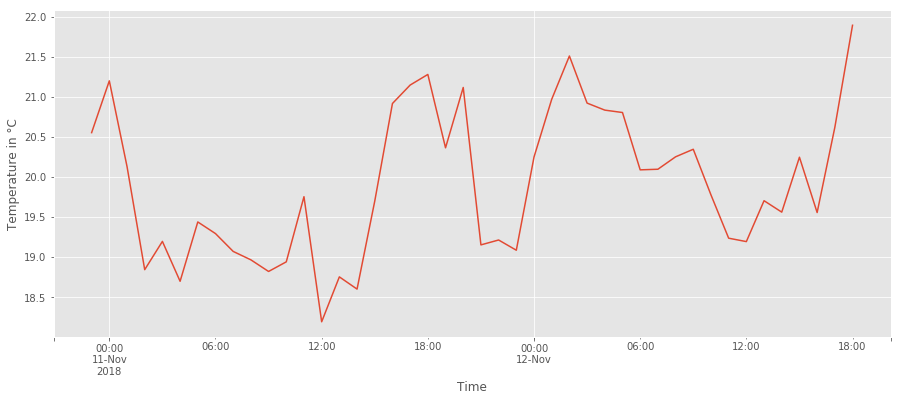

In [4]:
my_df = df['value'].resample('60T').mean()
my_df = my_df.fillna(my_df.bfill())
my_df.plot(figsize=(15, 6))
plt.ylabel("Temperature in °C")
plt.xlabel("Time")
plt.show()

In [5]:
q = d = range(0, 2)

p = range(0, 4)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [6]:
train_data = my_df['2018-11-11':]
test_data  = my_df['2018-11-13':]

In [7]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [8]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is -44.53051933439821 for model SARIMAX(2, 1, 0)x(3, 0, 0, 12)


In [9]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

ValueError: operands could not be broadcast together with shapes (9,) (2,) (9,) 

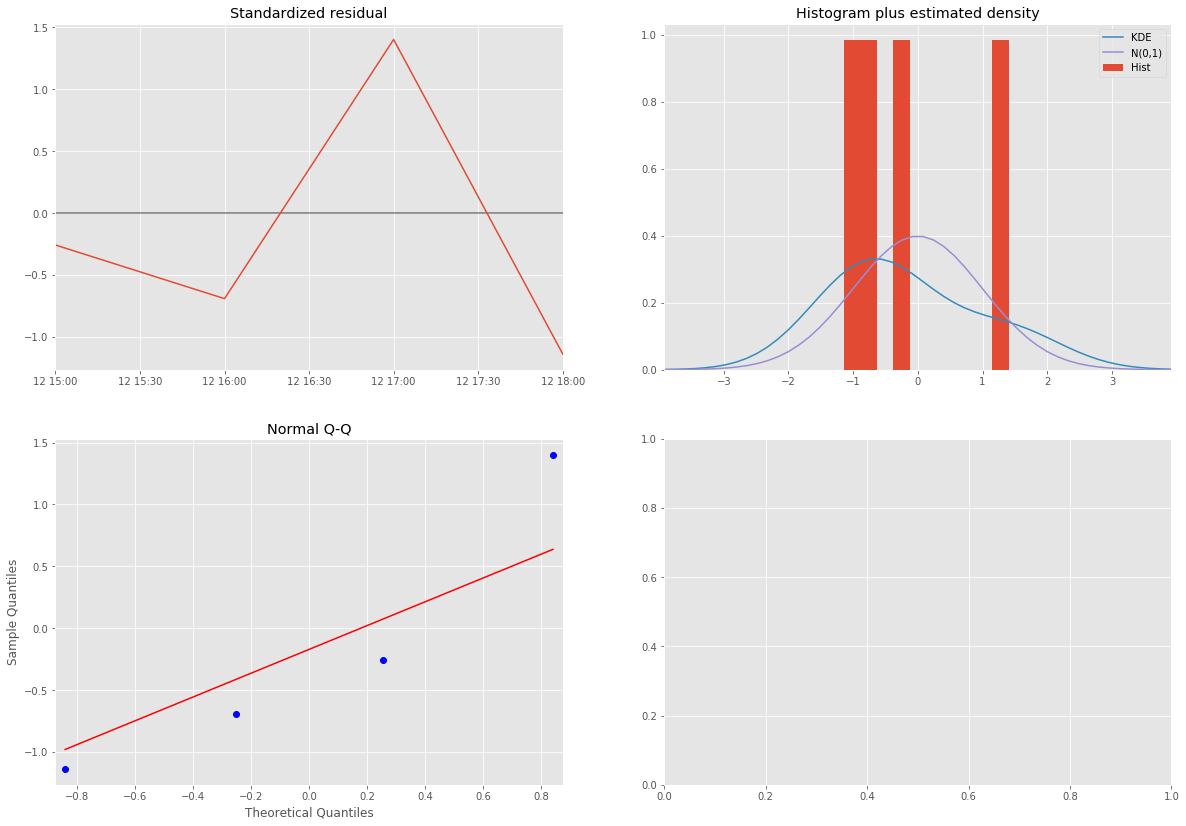

In [10]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In [ ]:

pred0 = results.get_prediction(start='2018-11-11', dynamic=False)
pred0_ci = pred0.conf_int()